# Notebook des graphes / maps
*Thomas FALSIMAGNE - Mickael FERNANDEZ (4A)*

---

## <span style="color: #0B582D">Table des matières :</span>
* [Import des librairies nécessaires à la génération des graphes / maps](#partie1)
* [Connexion à la session Oracle ](#partie2)
* [Cartographie représentant les ventes totales d'Occaski par zones géographiques](#partie3)
    * [Scripts Python pour exécuter des commandes PL/SQL depuis une base de données](#partie3_1)
* [Répartition des différents clients dans le chiffre d'affaires d'Occaski](#partie4)
    * [Scripts Python pour exécuter des commandes PL/SQL depuis une base de données](#partie4_1)
* [Historique mensuel des ventes en Suisse](#partie5)
    * [Scripts Python pour exécuter des commandes PL/SQL depuis une base de données](#partie5_1)
* [Les trois produits les plus populaires au niveau du chiffre d'affaires d'Occaski](#partie6)
    * [Scripts Python pour exécuter des commandes PL/SQL depuis une base de données](#partie6_1)
* [Chiffre d'affaires total par rapport au chiffre d'affaires des produits les moins vendus](#partie7)
    * [Scripts Python pour exécuter des commandes PL/SQL depuis une base de données](#partie7_1)
* [Chiffre d'affaires par client](#partie8)
    * [Scripts Python pour exécuter des commandes PL/SQL depuis une base de données](#partie8_1)
* [Références](#partie9)

***

## <span style="color: #0E169A">Import des librairies nécessaires à la génération des graphes / maps</span> <a class="anchor" id="partie1"></a>

In [1]:
import cx_Oracle
import folium
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patheffects import PathPatchEffect, SimpleLineShadow, Normal
from matplotlib.patches import Rectangle
import numpy as np

## <span style="color: #0E169A">Connexion à la session Oracle</span> <a class="anchor" id="partie2"></a>

<div class="alert alert-block alert-info">
<b>Information : </b> L'hôte, pour se connecter à n'importe quelle base de données, est nécessairement le même. Seul le nom d'utilisateur ainsi que le mot de passe changent.
</div>

In [2]:
dsn = cx_Oracle.makedsn(host='oracle.iut-blagnac.fr', port=1521, sid='db11g')

connection = cx_Oracle.connect(user = "SAEBD42", 
                               password = "blagnac",
                               dsn = dsn,
                               encoding = "UTF-8")

***

## <span style="color: #0E169A">Cartographie représentant les ventes totales de Occaski par zones géographiques</span> <a class="anchor" id="partie3"></a>

## <span style="color: #580B0B">Scripts Python pour exécuter des commandes PL/SQL depuis une base de données</span> <a class="anchor" id="partie3_1"></a>

<div class="alert alert-block alert-success">
<b>Précision : </b> Le code créé n'utilise aucune fonction pour cette partie. L'affichage final sera une carte interactive.
</div>

<div class="alert alert-block alert-warning">
<b>Attention : </b> Si vous avez une résolution d'écran faible, il se peut que la légende se superpose à la map interactive. Celle-ci peut alors être en plein milieu de la carte.
</div>

In [3]:
"""Exécution du script PL/SQL depuis la base de données"""

curseur = connection.cursor()
curseur2 = connection.cursor()

curseur.execute('SELECT PAYS \
                 FROM (SELECT DISTINCT(CL.adrPaysClient) AS PAYS, E.codeTypeTVA \
                       FROM ETIQUETTE E, CLIENT CL \
                       WHERE E.codeEtiquette = CL.codeEtiquette \
                       ORDER BY E.codeTypeTVA ASC)')

curseur2.execute('SELECT MONTANTVENTE \
                  FROM(SELECT E.codeTypeTVA, ROUND(SUM(CO.montantTTC)) AS MONTANTVENTE \
                  FROM ETIQUETTE E, CLIENT C, COMMANDE CO \
                  WHERE E.codeEtiquette = C.codeEtiquette \
                  AND C.numClient = CO.numClient \
                  GROUP BY E.codeTypeTVA)')

listepays = []
listeventes = []
listepc = []
totventes = 0

"""Récupération de l'ensemble des pays, constituant les clients d'Occaski"""
for elt in curseur:
    listepays += elt

"""Récupération des ventes effectuées selon le code type TVA des pays"""
for element in curseur2:
    listeventes += element

"""Récupération du montant total des ventes"""
for i in range(0, len(listeventes)):
    totventes += listeventes[i]

"""Répartition sous forme de pourcentage des ventes effectuées pour chaque client"""
for j in range(0, len(listeventes)):
    listepc.append(round((listeventes[j] / totventes * 100),3))
    
"""Réalisation de la map"""    

#Mise en place des couleurs / taille des cercles
colors = ["blue", "green", "green", "red", "red"]
radiuscircles = [listepc[0], listepc[1], listepc[1], listepc[2], listepc[2]]    

#Titre et éléments de la légende en HTML/CSS
loc = 'Cartographie representant les ventes totales de Occaski par zones geographiques'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)      

item_txt = """<br> &nbsp; {item} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{col}"></i>"""

html_itms = ""
for i in range(len(listepays)):
    html_itms += item_txt.format(item=listepays[i], col=colors[i])

legend_html = """
     <div style="
     position: fixed; 
     top: 50px; right: 60px; width: 150px; height: 170px; 
     border:2px solid grey; z-index:9999; 
     
     background-color:#0A0000;
     color:white;
     opacity: .80;
     
     font-size:14px;
     font-weight: bold;
     
     ">
     &nbsp; {title} 
     
     {item_txt}

      </div> """.format(title = "Legende", item_txt=html_itms)

#Construction de la map avec les coordonnées de Munich (étant les plus adaptées pour faire figurer les pays)
map = folium.Map(location=[48,11],
                 tiles="cartodbpositron",
                 zoom_start=4)

#Données des coordonnées des pays
data = pd.DataFrame({
    'lon':[2.213749, -1.1743197, 8.227512, 14.550072, 12.567380],
    'lat':[46.227638, 52.3555177, 46.818188, 47.516231, 41.871940],
    'name':listepays},
    dtype=str)

#Mise en place des markers des pays selon leurs coordonnées et leurs couleurs
for i in range(0,len(data)):
    folium.Marker(
       location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
       popup=data.iloc[i]['name'],
       icon=folium.Icon(color=colors[i])
    ).add_to(map)

#Mise en place des circlemarkers des pays selon leurs couleurs et la taille des cercles    
for i in range(0,len(data)):    
    folium.CircleMarker(
        location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
        fill_color=colors[i],
        color=colors[i],
        radius=radiuscircles[i]       
    ).add_to(map)

#Passage par méthodes pour faire figurer le code HTML du titre et de la légende de la map
map.get_root().html.add_child(folium.Element(title_html))
map.get_root().html.add_child(folium.Element(legend_html))

#Génération de la map
map

***

## <span style="color: #0E169A">Répartition des différents clients dans le chiffre d'affaires d'Occaski</span> <a class="anchor" id="partie4"></a>
## <span style="color: #580B0B">Scripts Python pour exécuter des commandes PL/SQL depuis une base de données</span> <a class="anchor" id="partie4_1"></a>

<div class="alert alert-block alert-success">
<b>Précision : </b> Le code crée n'utilise aucune fonction pour cette partie. L'affichage final sera un pie chart.
</div>

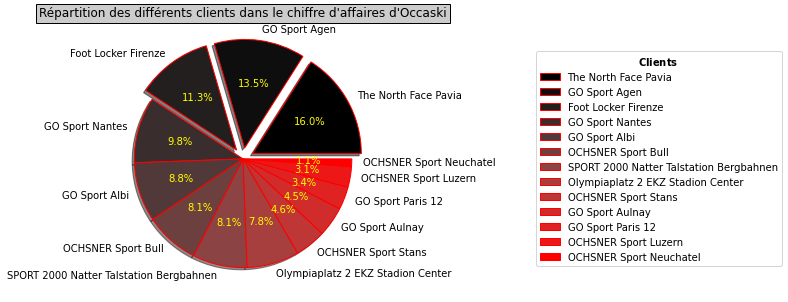

In [4]:
"""Exécution du script PL/SQL depuis la base de données"""

curseur3 = connection.cursor()

curseur3.execute('SELECT CL.nomClient AS CLIENTS, ROUND(SUM(D.montantTTC)) AS CHIFFRE_AFFAIRE \
                  FROM COMMANDE D, CLIENT CL, DETAIL_COMMANDE DC, TARIF_VENTE TF \
                  WHERE D.numClient = CL.numClient \
                  AND D.numCommande = DC.numCommande \
                  AND DC.numArticle = TF.numArticle \
                  GROUP BY CL.nomClient \
                  ORDER BY CHIFFRE_AFFAIRE DESC')

catotal = 0
listeclients = []
listeca = []

"""Récupération de manière décroissante des chiffres d'affaires des différents clients ainsi que des différents clients, de manière distincte"""
for elt in curseur3:
    listeclients.append(elt[0])
    listeca.append(elt[1])

for elts in listeca:
        catotal += elts
    
print("\n")

"""Récupération des différents clients d'Occaski de manière croissante, selon leur chiffre d'affaires"""

print("\n")

"""Réalisation du pie chart"""

#Fonction permettant de mettre sous forme de pourcentage, les différents chiffre d'affaire d'un client en fonction du total
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

#Taille du piechart
fig, ax = plt.subplots(figsize = (5,5))

#Mise en place et caractéristiques du pie chart (champs, pourcentages, séparations, couleurs, bordures, ...)
wedges, texts, autotexts = ax.pie(listeca,
                                  labels = listeclients,
                                  autopct = lambda pct: func(pct, listeca),
                                  shadow = True,
                                  explode = (0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
                                  colors = ("#000000", "#0F0E0E", "#241F1F", "#3A2D2D", 
                                            "#523939", "#6D4040", "#8C4343", "#A73F3F", 
                                            "#BE3636", "#D12C2C", "#E12222", "#ED1717", "#FF0000"),
                                  wedgeprops = {'linewidth' : 1, 'edgecolor' : "red"})

#Changement des couleurs insérées à l'intérieur du pie chart
for autotext in autotexts:
    autotext.set_color('yellow')

#Légende et titre du pie chart
ax.legend(title="$\\bf{Clients}$",
          loc = "center right",          
          bbox_to_anchor =(2, 0, 0.5, 1))
ax.set_title("Répartition des différents clients dans le chiffre d'affaires d'Occaski", bbox={'facecolor':'0.8', 'pad':3})

#Affichage du piechart
plt.show()

***

## <span style="color: #0E169A">Historique mensuel des ventes en Suisse</span> <a class="anchor" id="partie5"></a>
## <span style="color: #580B0B">Scripts Python pour exécuter des commandes PL/SQL depuis une base de données</span> <a class="anchor" id="partie5_1"></a>

<div class="alert alert-block alert-success">
<b>Précision : </b> Le code créé n'utilise aucune fonction pour cette partie. L'affichage final sera un diagramme à lignes brisées.
</div>

<div class="alert alert-block alert-danger">
<b>Avertissement:</b> Certains messages d'avertissement peuvent apparaître à l'exécution du script générant le graphe. Ici, l'erreur serait que l'ajout d'un axe utilisant les mêmes arguments qu'un axe précédent réutilise actuellement l'instance précédente.
</div>

/opt/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


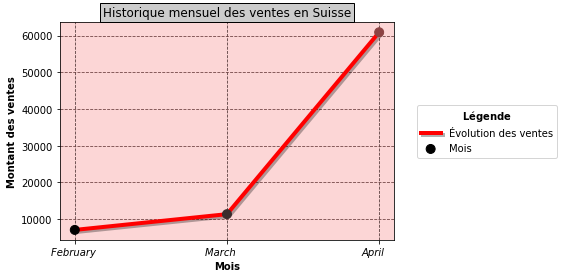

In [5]:
"""Exécution du script PL/SQL depuis la base de données"""

curseur4 = connection.cursor()
curseur5 = connection.cursor()

curseur4.execute('SELECT TO_CHAR(CO.dateCommande, \'Month\') AS MOIS \
                 FROM COMMANDE CO, CLIENT C \
                 WHERE CO.numClient = C.numClient \
                 AND C.adrPaysClient = \'Suisse\' \
                 AND TO_CHAR(CO.dateCommande,\'MM\') >= \'01\' \
                 GROUP BY CO.dateCommande \
                 ORDER BY TO_CHAR(CO.dateCommande, \'MM\')')

curseur5.execute('SELECT SUM(CO.montantTTC) AS MONTANTVENTE \
                 FROM COMMANDE CO, CLIENT C \
                 WHERE CO.numClient = C.numClient \
                 AND C.adrPaysClient = \'Suisse\' \
                 AND TO_CHAR(CO.dateCommande,\'MM\') >= \'01\' \
                 GROUP BY CO.dateCommande \
                 ORDER BY TO_CHAR(CO.dateCommande, \'MM\')')

listemois = []
listeventes = []

"""Récupération des mois dans l'ordre croissant"""
for elt in curseur4:
    listemois += elt

"""Récupération des ventes selon les mois dans l'ordre croissant"""
for elements in curseur5:
    listeventes += elements

"""Réalisation du scatter plot""" 

#Caractéristiques de la courbe selon les axes
plt.plot(listemois, listeventes, linestyle="-", color="#FF0000", linewidth='4', path_effects=
[SimpleLineShadow(), Normal()])

#Caractéristiques des points
plt.scatter(listemois, listeventes, color=["#000000", "#3A2D2D", "#8C4343"], s=80, zorder=10)

#Mise en place de la couleur de fond
ax = plt.axes()
ax.set(facecolor = '#FCD6D6')

#Ajout des titres des axes et personnalisation de la police pour les données
plt.xticks(style="italic")
plt.xlabel("Mois", fontweight='bold')
plt.ylabel("Montant des ventes", fontweight='bold')

#Personnalisation de la grille
plt.grid(axis='x', color='#523939', linestyle='dashed')
plt.grid(axis='y', color='#6D4040', linestyle='dashed')

#Mise en place du titre
plt.title("Historique mensuel des ventes en Suisse", bbox={'facecolor':'0.8', 'pad':3})

#Création d'une légende et de ses caractéristiques
plt.legend(['Évolution des ventes', 'Mois'],
           title="$\\bf{Légende}$",
           loc = "center right",          
           bbox_to_anchor =(1, 0, 0.5, 1))

plt.show()

***

## <span style="color: #0E169A">Les trois produits les plus populaires au niveau du chiffre d'affaires d'Occaski</span> <a class="anchor" id="partie6"></a>
## <span style="color: #580B0B">Scripts Python pour exécuter des commandes PL/SQL depuis une base de données</span> <a class="anchor" id="partie6_1"></a>

<div class="alert alert-block alert-success">
<b>Précision : </b> L'affichage final sera un pie chart.
</div>

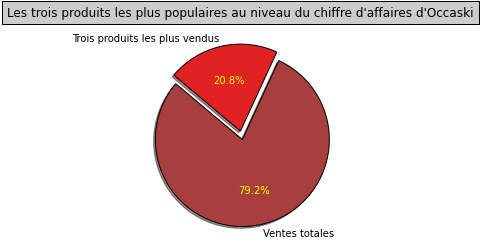

In [6]:
"""Exécution du script PL/SQL depuis la base de données"""

curseur6 = connection.cursor()
curseur7 = connection.cursor()

curseur6.execute("SELECT A.nomArticle, COUNT(DC.numArticle) AS NBCOMMANDE \
                 FROM ARTICLE A, DETAIL_COMMANDE DC \
                 WHERE A.numArticle = DC.numArticle \
                 GROUP BY A.nomArticle \
                 ORDER BY NBCOMMANDE DESC")

curseur7.execute("SELECT A.nomArticle, COUNT(DC.numArticle) AS NBCOMMANDE \
                  FROM ARTICLE A, DETAIL_COMMANDE DC \
                  WHERE A.numArticle = DC.numArticle \
                  GROUP BY A.nomArticle \
                  ORDER BY NBCOMMANDE DESC")

"""Récupération des articles les plus commandés chez Occaski"""
def listArticlesCommandes():
    list = []
    for elt in curseur6:
        list += elt
    return list 

def listArticlesCommandes2():
    list = []
    for elt in curseur7:
        list += elt
    return list 

"""Affectation à une liste des 3 articles les plus commandés"""
listeArticle = listArticlesCommandes()[:6]
"""Affectation à une liste de l'ensemble des articles commandés"""
listeTotale = listArticlesCommandes2()

"""Récupération du nombre des 3 articles les plus commandés chez Occaski"""
numbers = 0
for elt in listeArticle:
    if type(elt) == int:
        numbers += elt 
        
"""Récupération du nombre de l'ensemble des articles commandés chez Occaski"""        
numbersTot = 0
for elt in listeTotale: 
    if type(elt) == int:
        numbersTot += elt 
        
"""Réalisation du pie chart"""

#Données du plot
languages = 'Ventes totales', 'Trois produits les plus vendus'
popularity = [numbersTot, numbers]

#colors = ['red', 'gold']
colors = ["#A73F3F", "#E12222"]

#Explosion première découpe
explode = (0.1, 0)

#Plot
wedges, texts, autotexts = plt.pie(popularity, explode=explode, labels=languages, colors=colors,
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black"},
        autopct='%1.1f%%', shadow=True, startangle=140)

for autotext in autotexts:
    autotext.set_color('yellow')

plt.title("Les trois produits les plus populaires au niveau du chiffre d'affaires d'Occaski", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

## <span style="color: #0E169A">Chiffre d'affaires total par rapport au chiffre d'affaires des produits les moins vendus</span> <a class="anchor" id="partie7"></a>
## <span style="color: #580B0B">Scripts Python pour exécuter des commandes PL/SQL depuis une base de données</span> <a class="anchor" id="partie7_1"></a>

<div class="alert alert-block alert-success">
<b>Précision : </b>L'affichage final sera un pie chart.
</div>

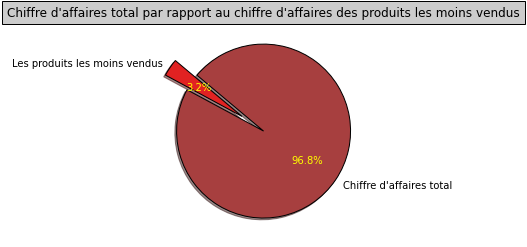

In [7]:
"""Exécution du script PL/SQL depuis la base de données"""

curseur8 = connection.cursor()
curseur9 = connection.cursor()

curseur8.execute("SELECT SUM(A.COUTACHAT * DC.QUANTITECOMMANDEE) AS MoinsCommandé \
                   FROM ARTICLE A, DETAIL_COMMANDE DC \
                   WHERE A.numArticle = DC.numArticle \
                   GROUP BY A.nomArticle \
                   HAVING COUNT(DC.numArticle) = (SELECT MIN(COUNT(DC.numArticle)) \
                                                  FROM DETAIL_COMMANDE DC \
                                                  GROUP BY DC.numArticle)")

curseur9.execute("SELECT ROUND(SUM(MONTANTTTC)) AS CHIFFRE_AFFAIRE \
                   FROM COMMANDE D ")

"""Récupération du chiffre d'affaire des produits les moins vendus"""
sousTot = 0
for elt in curseur8:
    sousTot+=int(elt[0])

"""Récupération du chiffre d'affaire total"""    
total = 0
for elt in curseur9:
    total+=int(elt[0])

"""Réalisation du pie chart"""    
    
#Données du plot
languages = 'Les produits les moins vendus', "Chiffre d'affaires total"
popularity = [sousTot, total]

#colors = ['red', 'gold']
colors = ["#E12222", "#A73F3F"]

#Explosion première découpe
explode = (0.3, 0)

#Plot
wedges, texts, autotexts = plt.pie(popularity, explode=explode, labels=languages, colors=colors, 
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black"},
        autopct='%1.1f%%', shadow=True, startangle=140)

for autotext in autotexts:
    autotext.set_color('yellow')
    
plt.title("Chiffre d'affaires total par rapport au chiffre d'affaires des produits les moins vendus", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

## <span style="color: #0E169A">Chiffre d'affaires par client</span> <a class="anchor" id="partie8"></a>
## <span style="color: #580B0B">Scripts Python pour exécuter des commandes PL/SQL depuis une base de données</span> <a class="anchor" id="partie8_1"></a>

<div class="alert alert-block alert-success">
<b>Précision : </b> Le code créé n'utilise aucune fonction pour cette partie. L'affichage final sera un diagramme à barres.
</div>

<div class="alert alert-block alert-danger">
<b>Avertissement:</b> Certains messages d'avertissement peuvent apparaître à l'exécution du script générant le graphe. Ici, l'erreur serait que l'ajout d'un axe utilisant les mêmes arguments qu'un axe précédent réutilise actuellement l'instance précédente.
</div>

/opt/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


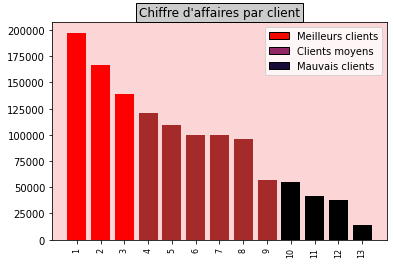

In [11]:
curseur10 = connection.cursor()


curseur10.execute('SELECT CL.NOMCLIENT, ROUND(SUM(C.MONTANTTTC))\
                FROM DETAIL_COMMANDE DC, TARIF_VENTE TV, CLIENT CL, COMMANDE C\
                WHERE DC.NUMARTICLE = TV.NUMARTICLE\
                AND DC.NUMCOMMANDE = C.NUMCOMMANDE\
                AND C.NUMCLIENT = CL.NUMCLIENT \
                GROUP BY CL.NOMCLIENT\
                ORDER BY SUM(C.MONTANTTTC) DESC')
noms4 = []
valeurs4 = []

"""Récupération des clients et de leur chiffre d'affaires séparément"""
for elt in curseur10:
    valeurs4.append(elt[1])
    
i = 1
taille = 0
    
while taille != len(valeurs4):
    noms4.append(i)
    i +=1
    taille +=1
    
"""Diagramme à bâtons"""

#Données et esthétisme du diagramme 
cmap = plt.get_cmap('jet')
cmap2 = plt.get_cmap('inferno')
low = cmap(0.9)
medium =cmap2(0.40)
high = cmap2(0.1)

plt.title("Chiffre d'affaires par client", bbox={'facecolor':'0.8', 'pad':3})
plt.bar(range(len(noms4)), valeurs4, tick_label=noms4, color=['red', 'red', 'red', 'brown', 'brown', 'brown', 'brown', 'brown','brown','black','black','black', 'black'])
#plt.savefig('caCli.png')
plt.xticks(fontsize=8, rotation=90)

ax = plt.axes()
ax.set(facecolor = '#FCD6D6')

#Création de la légende et affichage
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low, medium, high]]
labels= ["Meilleurs clients","Clients moyens", "Mauvais clients"]
plt.legend(handles, labels)
plt.savefig('waw.png')

plt.show()

## <span style="color: #0E169A">Références</span> <a class="anchor" id="partie9"></a>

Pour les références à la réalisation du notebook, veuillez cliquer ici : [<span style="color: #26B260">Notebook</span>](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet)</span>. <br/>
Pour les références générales à la réalisation des différents diagrammes / maps, veuillez cliquer ici : [<span style="color: blue">Diagrammes et maps</span>](https://www.python-graph-gallery.com/)</span>.